In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score


import hdbscan

In [4]:
X_pca = pd.read_csv("pca_transformed_data.csv")

print("Shape:", X_pca.shape)
X_pca.head()

Shape: (52585, 5)


,PC1,PC2,PC3,PC4,PC5
0,1.518696,-0.277912,0.347350,0.705358,0.522821
1,-0.785274,-0.236020,0.403533,1.196335,-0.803506
2,0.986585,-1.592196,-1.194400,0.924828,-0.799127
3,1.219528,-1.082553,-1.003398,0.878745,1.096236
4,-1.462096,0.033606,1.130637,-0.884248,-0.194635


In [5]:
K_range = range(2, 11)

gmm_sil = []
gmm_ch = []
gmm_db = []
gmm_bic = []
gmm_aic = []

for k in K_range:
    gmm = GaussianMixture(n_components=k, 
                          covariance_type='full',  # elliptical clusters
                          random_state=42)
    
    labels = gmm.fit_predict(X_pca)
    
    gmm_sil.append(silhouette_score(X_pca, labels))
    gmm_ch.append(calinski_harabasz_score(X_pca, labels))
    gmm_db.append(davies_bouldin_score(X_pca, labels))
    gmm_bic.append(gmm.bic(X_pca))
    gmm_aic.append(gmm.aic(X_pca))

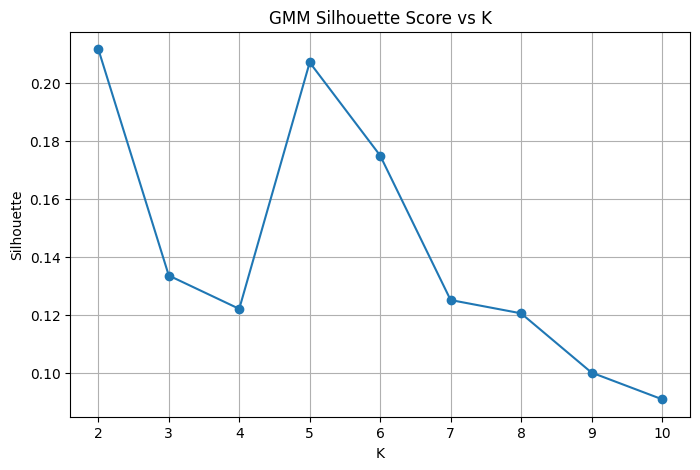

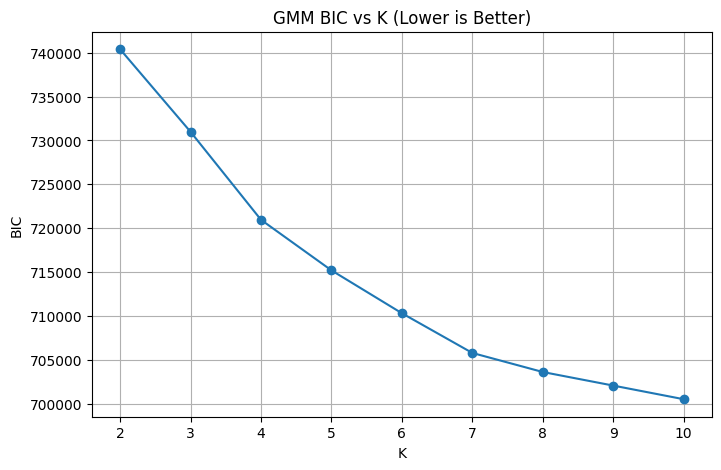

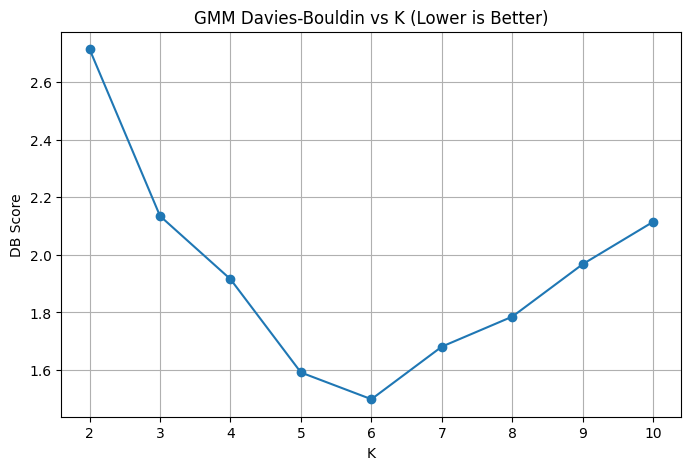

In [6]:
plt.figure(figsize=(8,5))
plt.plot(K_range, gmm_sil, marker='o')
plt.title("GMM Silhouette Score vs K")
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.grid()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(K_range, gmm_bic, marker='o')
plt.title("GMM BIC vs K (Lower is Better)")
plt.xlabel("K")
plt.ylabel("BIC")
plt.grid()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(K_range, gmm_db, marker='o')
plt.title("GMM Davies-Bouldin vs K (Lower is Better)")
plt.xlabel("K")
plt.ylabel("DB Score")
plt.grid()
plt.show()

In [7]:
for i, k in enumerate(K_range):
    print(f"K={k} | Sil={gmm_sil[i]:.4f} | CH={gmm_ch[i]:.2f} | DB={gmm_db[i]:.4f} | BIC={gmm_bic[i]:.2f}")

K=2 | Sil=0.2115 | CH=5326.57 | DB=2.7134 | BIC=740386.58
K=3 | Sil=0.1336 | CH=5789.26 | DB=2.1345 | BIC=730984.37
K=4 | Sil=0.1221 | CH=6198.29 | DB=1.9152 | BIC=720966.59
K=5 | Sil=0.2070 | CH=7417.07 | DB=1.5914 | BIC=715209.15
K=6 | Sil=0.1749 | CH=7708.38 | DB=1.4987 | BIC=710327.31
K=7 | Sil=0.1251 | CH=6400.68 | DB=1.6812 | BIC=705805.10
K=8 | Sil=0.1205 | CH=5832.19 | DB=1.7853 | BIC=703635.62
K=9 | Sil=0.1001 | CH=6560.26 | DB=1.9675 | BIC=702090.58
K=10 | Sil=0.0910 | CH=6052.09 | DB=2.1145 | BIC=700538.29


In [8]:
best_k = 5
gmm_final = GaussianMixture(n_components=best_k, 
                            covariance_type='full',
                            random_state=42)

gmm_labels = gmm_final.fit_predict(X_pca)

X_pca['GMM_Cluster'] = gmm_labels

Hdbscan

In [9]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=200,
    min_samples=10
)

hdb_labels = clusterer.fit_predict(X_pca)

In [10]:
unique_clusters = np.unique(hdb_labels)
print("Clusters found:", unique_clusters)
print("Number of clusters (excluding noise):",
      len(unique_clusters[unique_clusters != -1]))

Clusters found: [-1  0  1  2  3  4  5]
Number of clusters (excluding noise): 6


In [11]:
mask = hdb_labels != -1

if len(np.unique(hdb_labels[mask])) > 1:
    sil = silhouette_score(X_pca[mask], hdb_labels[mask])
    ch = calinski_harabasz_score(X_pca[mask], hdb_labels[mask])
    db = davies_bouldin_score(X_pca[mask], hdb_labels[mask])
    
    print("HDBSCAN Silhouette:", sil)
    print("HDBSCAN CH:", ch)
    print("HDBSCAN DB:", db)

HDBSCAN Silhouette: 0.2466291558071229
HDBSCAN CH: 6503.98313331527
HDBSCAN DB: 1.2682426820893853


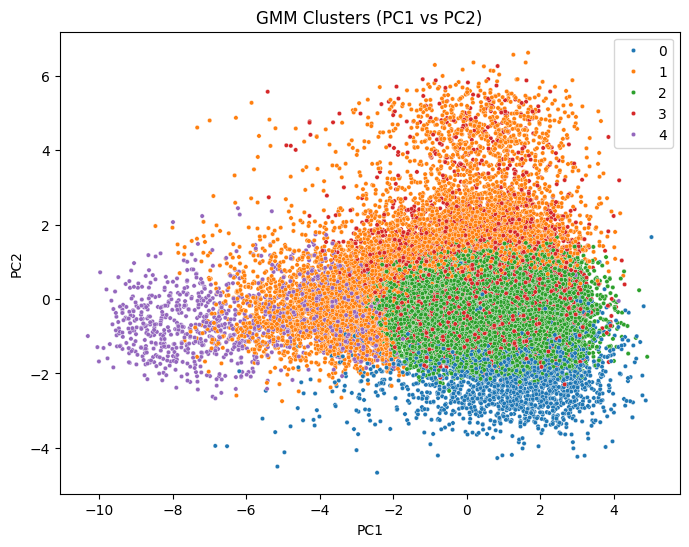

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca['PC1'],
    y=X_pca['PC2'],
    hue=gmm_labels,
    palette='tab10',
    s=10
)
plt.title("GMM Clusters (PC1 vs PC2)")
plt.show()

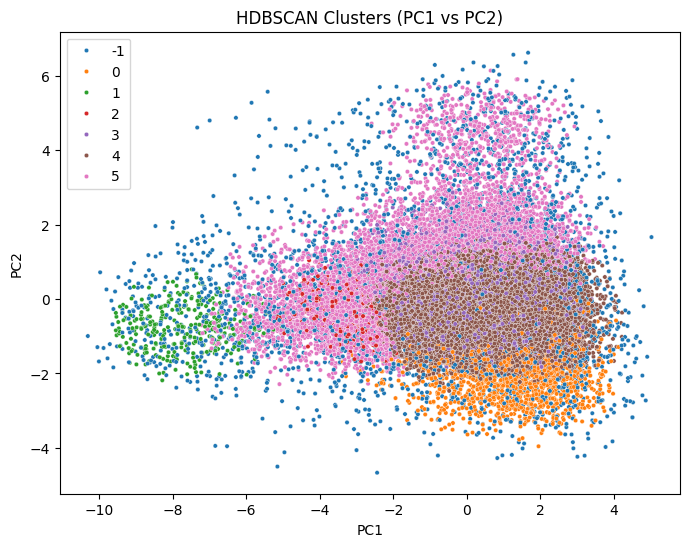

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_pca['PC1'],
    y=X_pca['PC2'],
    hue=hdb_labels,
    palette='tab10',
    s=10
)
plt.title("HDBSCAN Clusters (PC1 vs PC2)")
plt.show()

In [14]:
comparison = pd.DataFrame({
    "Model": ["KMeans", "GMM", "HDBSCAN"],
    "Silhouette": [0.239, max(gmm_sil), sil],
})

comparison

,Model,Silhouette
0,KMeans,0.239000
1,GMM,0.211507
2,HDBSCAN,0.246629
